Imports

In [1]:
import pandas as pd
import numpy as np
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
import re
import matplotlib.pyplot as plt
%matplotlib inline

## Text preprocessing

In [2]:
twit = pd.read_csv('./olavotwits.csv')

In [3]:
twit = twit.dropna()

1. Remoção de links, pois esses termos não possuem conteúdo semântico;
2. Transformando 'n' em nao;
3. Remoção de repetição de letras;
4. Remoção de citação a outros usuários;
5. Conversão de letras maiúsculas em minúsculas, a fim de padronizar o texto;
6. Remoção de caracteres não alfabéticos e pontuação;
7. Remoção de caracteres numéricos;
8. Remoção de espaços duplos;

In [4]:
def pre_process(df):
    df['text_process'] = df['text'].apply(lambda x: re.sub(r"http\S+", "",x)) # 1
    df['text_process'] = df['text_process'].apply(lambda x: re.sub(r"pic.twitter\S+", "",x)) # 1
    df['text_process'] = df['text_process'].apply(lambda x: re.sub(r'\bn\b', 'nao',x, flags=re.IGNORECASE)) #2
    df['text_process'] = df['text_process'].apply(lambda x: re.sub(r'(\w)(\1{2,})', r'\1',x)) # 3
    df['text_process'] = df['text_process'].apply(lambda x: re.sub(r'\B@\w+', '',x)) # 4
    df['text_process'] = df['text_process'].apply(lambda x: x.lower()) # 5
    df['text_process'] = df['text_process'].apply(lambda x: re.sub(r'[\W*]+', ' ',x)) # 6
    df['text_process'] = df['text_process'].apply(lambda x: re.sub(r'[0-9]', '',x)) # 7
    df['text_process'] = df['text_process'].apply(lambda x: re.sub(r'\b  \b', ' ',x)) # 9
    
    # Abreviações básicas
    df['text_process'] = df['text_process'].apply(lambda x: re.sub(r'\bpq\b', 'porque',x)) 
    df['text_process'] = df['text_process'].apply(lambda x: re.sub(r'\bvc\b', 'você',x)) 
    df['text_process'] = df['text_process'].apply(lambda x: re.sub(r'\bvcs\b', 'você',x)) 
    df['text_process'] = df['text_process'].apply(lambda x: re.sub(r'\btb\b', 'também',x)) 
    df['text_process'] = df['text_process'].apply(lambda x: re.sub(r'\btbm\b', 'também',x)) 
    df['text_process'] = df['text_process'].apply(lambda x: re.sub(r'\bpra\b', 'para',x)) 
    df['text_process'] = df['text_process'].apply(lambda x: re.sub(r'\bsr\b', 'senhor',x))
    df['text_process'] = df['text_process'].apply(lambda x: re.sub(r'\bta\b', 'está',x)) 
    df['text_process'] = df['text_process'].apply(lambda x: re.sub(r'\bq\b', 'que',x))

    return df

In [5]:
import warnings
warnings.filterwarnings('ignore')

twit = pre_process(twit)
twit.head()

,Unnamed: 0,text,date,text_process
0,0,"Desde ANTES da posse do Bolsonaro, avisei que,...",2019-12-30 17:33:26+00:00,desde antes da posse do bolsonaro avisei que s...
1,1,"A autora é minha prima, e conhece este assunto...",2019-12-30 16:50:52+00:00,a autora é minha prima e conhece este assunto
2,2,https://www.youtube.com/watch?v=OdUA2p5R-Gk,2019-12-30 16:33:20+00:00,
3,3,"Existe algum modo ""pragmatista"" de enfrentar p...",2019-12-30 16:27:41+00:00,existe algum modo pragmatista de enfrentar per...
4,4,https://brasilsemmedo.com/olavo-em-portugal/,2019-12-30 15:48:49+00:00,


Carregando stopwords...

In [6]:
from nltk.corpus import stopwords
stops = nltk.corpus.stopwords.words('portuguese')
stops.extend(['la', 'lo', 'los'])

#### Part-of-speech tagging

Pode ser usado para filtrar substantivos ou verbos na sentença; identificar relações gramaticais.

In [7]:
from nltk import UnigramTagger as ut
from nltk.corpus import floresta

flo_sents = floresta.tagged_sents()
uni = ut(flo_sents)

uni.tag(twit['text_process'][0].split(" "))

[('desde', 'H+prp'),
 ('antes', 'H+adv'),
 ('da', None),
 ('posse', 'H+n'),
 ('do', None),
 ('bolsonaro', None),
 ('avisei', None),
 ('que', 'SUBJ+pron-indp'),
 ('sem', 'H+prp'),
 ('fechar', 'P+v-inf'),
 ('os', '>N+art'),
 ('partidos', 'H+n'),
 ('ilegais', 'N<+adj'),
 ('e', 'CO+conj-c'),
 ('cassar', 'P+v-inf'),
 ('os', '>N+art'),
 ('direitos', 'H+n'),
 ('políticos', 'N<+adj'),
 ('dos', None),
 ('seus', '>N+pron-det'),
 ('dirigentes', 'H+n'),
 ('o', '>N+art'),
 ('governo', 'H+n'),
 ('estaria', 'AUX+v-fin'),
 ('de', 'H+prp'),
 ('mãos', 'H+n'),
 ('amarradas', None),
 ('e', 'CO+conj-c'),
 ('pronto', 'H+adj'),
 ('a', '>N+art'),
 ('ser', 'AUX+v-inf'),
 ('destruído', 'MV+v-pcp'),
 ('a', '>N+art'),
 ('qualquer', '>N+pron-det'),
 ('momento', 'H+n'),
 ('', None)]

Função para [lemmatizar](https://en.wikipedia.org/wiki/Lemmatisation), remover pontuação e remover stopwords

In [8]:
import string
from nltk.stem.wordnet import WordNetLemmatizer

def clean(text):
    exclude = set(string.punctuation) 
    lemma = WordNetLemmatizer()
    doc = text
    stop_free = " ".join([i for i in doc.lower().split() if i not in stops])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized


In [9]:
twit['clean_text'] = [clean(t) for t in twit['text_process'].values]
twit.head()

,Unnamed: 0,text,date,text_process,clean_text
0,0,"Desde ANTES da posse do Bolsonaro, avisei que,...",2019-12-30 17:33:26+00:00,desde antes da posse do bolsonaro avisei que s...,desde ante posse bolsonaro avisei fechar parti...
1,1,"A autora é minha prima, e conhece este assunto...",2019-12-30 16:50:52+00:00,a autora é minha prima e conhece este assunto,autora prima conhece assunto
2,2,https://www.youtube.com/watch?v=OdUA2p5R-Gk,2019-12-30 16:33:20+00:00,,
3,3,"Existe algum modo ""pragmatista"" de enfrentar p...",2019-12-30 16:27:41+00:00,existe algum modo pragmatista de enfrentar per...,existe algum modo pragmatista enfrentar perigos
4,4,https://brasilsemmedo.com/olavo-em-portugal/,2019-12-30 15:48:49+00:00,,


### Bag-of-words e Wordcloud

Abaixo gero uma 'bag-of-words', que é nada mais que uma tabela-frequência das palavras no texto.

Existem outras formas de realizar a contagem, como *Tfidf* ou *Term-frequency times Inverse-document-frequency*, que é como uma média ponderada, em que se realiza uma comparação entre diferentes colunas, com palavras que são mais únicas a cada coluna tendo pesos maiores para aquela respectiva coluna.

In [10]:
import nltk

# Funções para bag of words
def get_all_words(tweets):
    all_words = []
    for words in tweets:
        all_words.extend(words.split())
    return all_words

def get_bag_of_words(all_words):
    return nltk.FreqDist(w.lower() for w in all_words)

In [11]:
all_words = get_all_words(twit["clean_text"]) # Escolha a coluna a ser analisada
bag_of_words = get_bag_of_words(all_words)

In [12]:
print(bag_of_words.most_common(30))

[('brasil', 163), ('mídia', 125), ('contra', 123), ('ser', 100), ('nunca', 94), ('nada', 92), ('sobre', 91), ('toda', 87), ('todos', 84), ('ano', 77), ('santos', 77), ('mim', 75), ('governo', 72), ('hoje', 70), ('cruz', 68), ('pode', 66), ('bolsonaro', 64), ('tudo', 63), ('presidente', 62), ('política', 62), ('olavo', 61), ('ter', 61), ('qualquer', 60), ('paulo', 60), ('ainda', 59), ('dia', 58), ('apenas', 56), ('brasileira', 55), ('direita', 54), ('poder', 53)]


In [13]:
flag = np.array(Image.open("./download.png"))
image_colors = ImageColorGenerator(flag)

In [14]:
def print_wordcloud(data, bg_color):
    words = ' '.join(data)
    wordcloud = WordCloud(stopwords=stops,
                  background_color=bg_color,
                  width=640,
                  height=448,
                  mask=flag
                ).generate(words)
    plt.figure(figsize=(15, 15))
    plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
    plt.axis('off')
    plt.show()

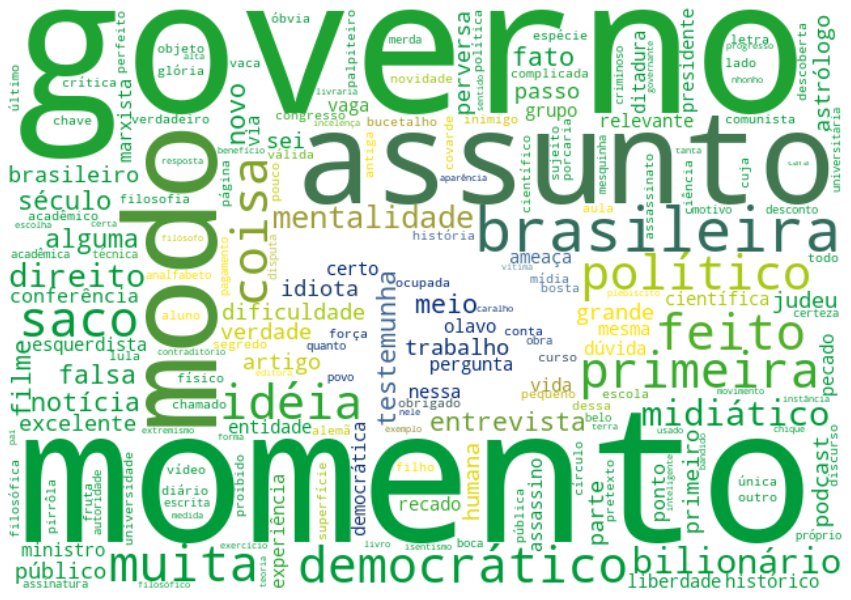

In [15]:
print_wordcloud(bag_of_words, 'white')

### Word2Vec e word-embeddings

Abaixo, preprocesso os tweets como palavras separadas dentro de nested lists, o formato necessário para fazer word-embedding.

Esse Word2Vec vai estabelecer semelhanças entre palavras de acordo com a frequência que elas aparecem juntas em um corpo de texto. 

In [18]:
individualized = []
for index,row in twit.iterrows():
    if row['clean_text'] != '':
        process = [[word for word in row['clean_text'].lower().split()]]
        individualized.extend(process)
individualized[0:3]

[['desde',
  'ante',
  'posse',
  'bolsonaro',
  'avisei',
  'fechar',
  'partidos',
  'ilegais',
  'cassar',
  'direitos',
  'políticos',
  'dirigentes',
  'governo',
  'estaria',
  'mãos',
  'amarradas',
  'pronto',
  'ser',
  'destruído',
  'qualquer',
  'momento'],
 ['autora', 'prima', 'conhece', 'assunto'],
 ['existe', 'algum', 'modo', 'pragmatista', 'enfrentar', 'perigos']]

In [19]:
import gensim

unable to import 'smart_open.gcs', disabling that module


In [29]:
model = gensim.models.Word2Vec(individualized, size=100, window=5, min_count=1, workers=2, sg=2)

In [30]:
vocabulary = list(model.wv.vocab.items())

Palavras semelhantes a 'presidente' no corpo de tweets.

In [33]:
similar_to = model.most_similar("presidente", topn=5)
similar_to

[('governo', 0.99798983335495),
 ('brasil', 0.9979398250579834),
 ('dia', 0.997935950756073),
 ('mim', 0.9979294538497925),
 ('bolsonaro', 0.9979190230369568)]